In [42]:
%load_ext autoreload
%autoreload 2

In [43]:
import sys
sys.path.insert(0, '../scripts/')

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from causalnex.structure import DAGClassifier
from sklearn.metrics import jaccard_score
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [77]:
root_dir = Path().cwd().parent
data_dir = root_dir / "data"

In [78]:
df = pd.read_csv(data_dir / "data_clean.csv")

In [79]:
df["diagnosis"] = df["diagnosis"].apply(lambda x: 0 if x == "M" else 1)

In [80]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,...,25.380,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890
1,842517,0,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902
2,84300903,0,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,...,14.910,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301
4,84358402,0,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,0,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115
565,926682,0,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637
566,926954,0,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820
567,927241,0,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,...,25.740,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301


In [81]:
standard_scaler = StandardScaler()

In [82]:
X = df.iloc[:, 2:]
y = df["diagnosis"]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [84]:
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

MEAN Score: 0.975
MEAN EFFECT DIRECTIONAL CLASS 0:
compactness_se             0.404760
fractal_dimension_se       0.334037
compactness_mean           0.300730
texture_se                 0.274312
symmetry_se                0.190629
compactness_worst          0.038199
radius_mean                0.037522
texture_mean              -0.000034
symmetry_mean             -0.002285
perimeter_mean            -0.011182
smoothness_mean           -0.028504
area_mean                 -0.034237
smoothness_se             -0.059310
perimeter_se              -0.088082
fractal_dimension_mean    -0.098429
concavity_worst           -0.116531
concave points_worst      -0.172433
smoothness_worst          -0.174506
concavity_se              -0.174822
radius_se                 -0.209381
symmetry_worst            -0.226688
fractal_dimension_worst   -0.243414
concave points_se         -0.269983
perimeter_worst           -0.273686
concave points_mean       -0.361007
area_worst                -0.370589
radius_worst 

(<Figure size 1185.84x902.16 with 1 Axes>, <AxesSubplot:>)

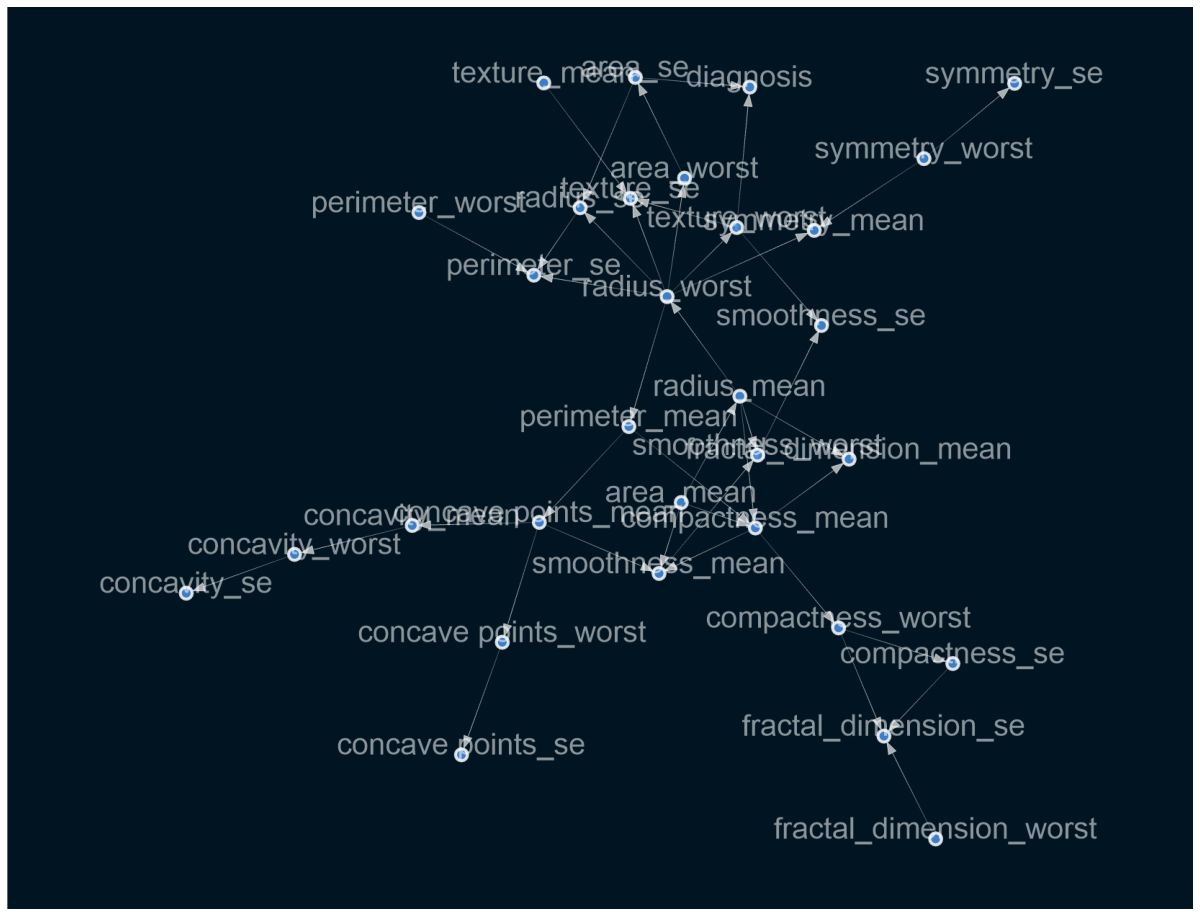

In [94]:
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

clf.fit(X, y)

for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X.columns.tolist()).sort_values(ascending=False))
    
ground_truth = clf.coef_[i, :]
clf.plot_dag(True)

In [97]:
features = [
    "compactness_se",      
    "fractal_dimension_se",
    "compactness_mean",   
    "texture_se",          
    "symmetry_se",         
    "compactness_worst",          
    "radius_mean",              
]

In [117]:
X_50 = X.sample(frac=0.5)
y_50 = y.iloc[X_50.index.tolist()]

MEAN EFFECT DIRECTIONAL CLASS 0:
fractal_dimension_se       0.396189
compactness_se             0.358784
texture_se                 0.281143
fractal_dimension_mean     0.165138
symmetry_se                0.124634
smoothness_mean            0.013258
concavity_se               0.000402
symmetry_mean             -0.003741
smoothness_se             -0.010213
compactness_mean          -0.029139
texture_mean              -0.045578
radius_mean               -0.057076
area_mean                 -0.060063
perimeter_mean            -0.066582
concavity_worst           -0.074241
symmetry_worst            -0.127949
smoothness_worst          -0.129425
area_worst                -0.164630
concave points_se         -0.165785
concave points_worst      -0.166851
perimeter_worst           -0.171380
compactness_worst         -0.176205
area_se                   -0.182476
radius_worst              -0.204389
concavity_mean            -0.222043
perimeter_se              -0.247449
fractal_dimension_worst   -0.38

(<Figure size 759.6x548.64 with 1 Axes>, <AxesSubplot:>)

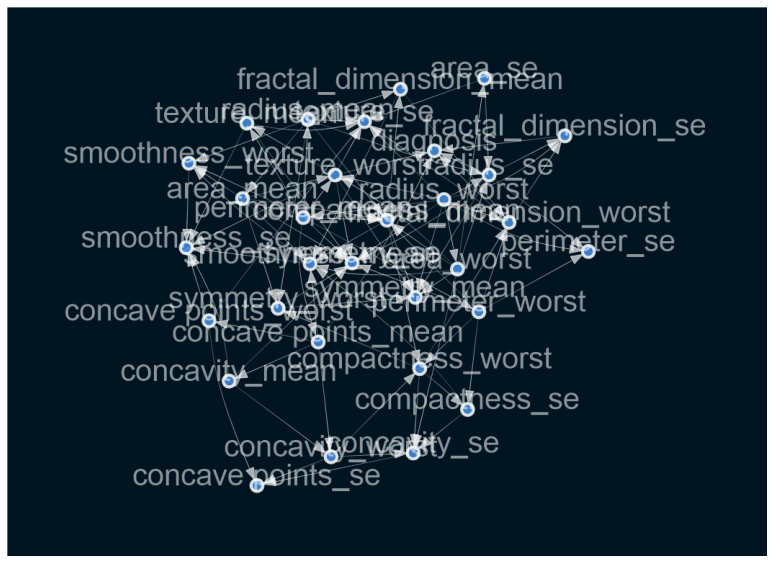

In [120]:
clf.fit(X_50, y_50)

for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X_50.columns.tolist()).sort_values(ascending=False))

new_coefs = clf.coef_[i, :]
clf.plot_dag(True)

In [128]:
# similarity = jaccard_score(ground_truth, new_coefs)

# print(f'Jaccard similarity is equal to: {similarity}')